In [1]:
import pandas as pd
# import shutil 
import os
import tensorflow as tf
import matplotlib.pyplot as plt # to plot
import matplotlib.image as mpimg 
import tensorflow as tf # to implement deep learning model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, SpatialDropout2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator # to augment and read the files from directory
from tensorflow.keras.applications.inception_v3 import InceptionV3 # Pre trained Inception model
from tensorflow.keras import Model
from keras.preprocessing import image
from keras.models import load_model

In [2]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
IMAGE_PATH = os.path.join(DATA_PATH, 'images')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'val')

## Data Visualization

## Modeling Approaches

In [3]:
#Building the model from scratch
model = tf.keras.models.Sequential([
    
    # building a sequential model with input as (150, 150)
    Conv2D(16, (3,3), # 16 filters of size 3,3
           activation='relu', # RELU activation
           input_shape=(150, 150, 3)),
    MaxPooling2D(2,2), # Maxpooling layer to extract the dominant features
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2), 
    
    Conv2D(64, (3,3), activation='relu'), 
    MaxPooling2D(2,2),
    
    Flatten(), # flattening 
    
    Dense(512, activation='relu'), # Dense layer with 512 neurons

    Dense(4, activation='softmax')  # AS it is a multi class classification
])
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

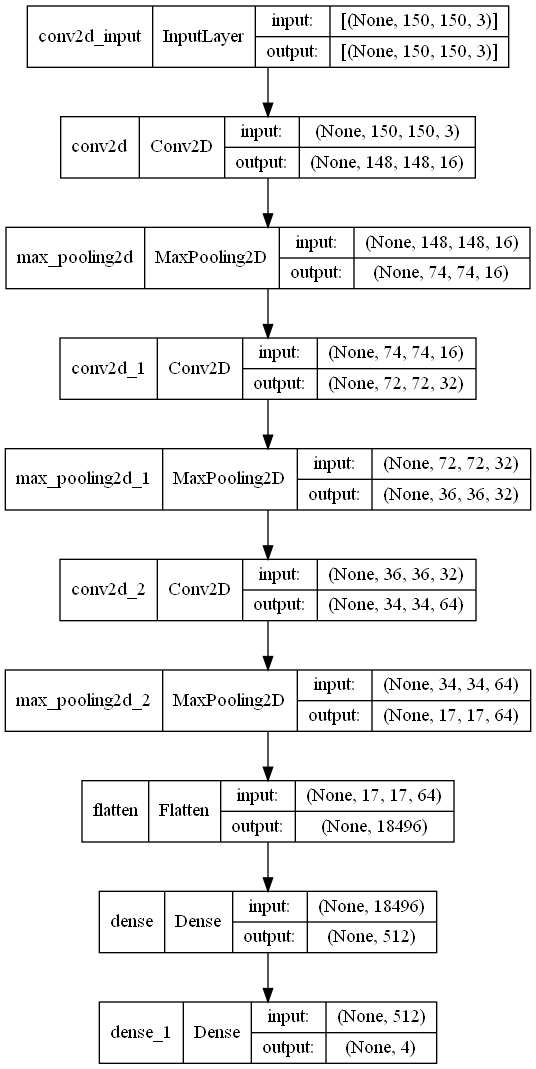

In [6]:
dot_img_file = '/model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [4]:
#Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), # Adam optimizer
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [5]:

#Using ImageDataGenerator to read the data
train_datagen = ImageDataGenerator( rescale = 1.0/255. ) # Rescaling the images to get efficient and fast results
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# Using flow_from_directory method to read images from the directory
train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))   

# Using flow_from_directory method to read images from the directory
validation_generator =  test_datagen.flow_from_directory(VAL_PATH,
                                                         batch_size=128,
                                                         class_mode  = 'categorical',
                                                         target_size = (150, 150))

Found 1457 images belonging to 4 classes.
Found 364 images belonging to 4 classes.


In [5]:
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}): # this method will be called everytime at the end of each epoch
        if(logs.get('accuracy')>0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True
            
callback = myCallback()

In [7]:
#Training the model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50, callbacks= [callback])

Epoch 1/50
12/12 [==============================] - 22s 2s/step - loss: 1.7751 - accuracy: 0.3123 - val_loss: 1.3219 - val_accuracy: 0.3407
Epoch 2/50
12/12 [==============================] - 18s 2s/step - loss: 1.2455 - accuracy: 0.3274 - val_loss: 1.2385 - val_accuracy: 0.3709
Epoch 3/50
12/12 [==============================] - 19s 2s/step - loss: 1.1832 - accuracy: 0.4393 - val_loss: 1.1854 - val_accuracy: 0.4368
Epoch 4/50
12/12 [==============================] - 18s 1s/step - loss: 1.0911 - accuracy: 0.5388 - val_loss: 1.2183 - val_accuracy: 0.4258
Epoch 5/50
12/12 [==============================] - 18s 2s/step - loss: 1.0183 - accuracy: 0.5628 - val_loss: 1.1454 - val_accuracy: 0.5192
Epoch 6/50
12/12 [==============================] - 18s 1s/step - loss: 1.0131 - accuracy: 0.5649 - val_loss: 1.1639 - val_accuracy: 0.4588
Epoch 7/50
12/12 [==============================] - 17s 1s/step - loss: 0.9116 - accuracy: 0.6328 - val_loss: 1.1733 - val_accuracy: 0.5000
Epoch 8/50
12/12 [==

In [13]:
#Model's Accuracy & Loss
def plot_acc_loss(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.show()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
# plot_acc_loss(history)

## Data Augmentation
Data augmentation is a technique that can be used to genrate more images by using rotation, cropping, shifting, flipping, etc.
This will results in increase in the datasize and reduce in overfitting.

In [3]:
train_datagen = ImageDataGenerator(# now it is also used for data augmentation
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) # not applying to test set

train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  # This is the source directory for training images
        target_size=(150, 150),  
        batch_size=128,
        class_mode='categorical')# As this is binary classification

validation_generator = test_datagen.flow_from_directory(
        VAL_PATH,
        target_size=(150, 150),
        batch_size=128,
        class_mode='categorical')

Found 1457 images belonging to 4 classes.
Found 364 images belonging to 4 classes.


In [17]:
print(train_generator.class_indices)

{'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}


In [7]:
#Training the new model with augmented data
model_2 = tf.keras.models.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])

history_2 = model_2.fit(
      train_generator,
      epochs=100,
      validation_data=validation_generator, callbacks = [callback])

Epoch 1/100
12/12 [==============================] - 24s 2s/step - loss: 1.2761 - accuracy: 0.3061 - val_loss: 1.2560 - val_accuracy: 0.3791
Epoch 2/100
12/12 [==============================] - 23s 2s/step - loss: 1.2593 - accuracy: 0.3253 - val_loss: 1.2572 - val_accuracy: 0.3104
Epoch 3/100
12/12 [==============================] - 24s 2s/step - loss: 1.2495 - accuracy: 0.3294 - val_loss: 1.2445 - val_accuracy: 0.3571
Epoch 4/100
12/12 [==============================] - 23s 2s/step - loss: 1.2244 - accuracy: 0.3693 - val_loss: 1.4134 - val_accuracy: 0.3736
Epoch 5/100
12/12 [==============================] - 24s 2s/step - loss: 1.2328 - accuracy: 0.3631 - val_loss: 1.2176 - val_accuracy: 0.4093
Epoch 6/100
12/12 [==============================] - 22s 2s/step - loss: 1.1896 - accuracy: 0.4118 - val_loss: 1.2205 - val_accuracy: 0.3956
Epoch 7/100
12/12 [==============================] - 23s 2s/step - loss: 1.1869 - accuracy: 0.4255 - val_loss: 1.2814 - val_accuracy: 0.4121
Epoch 8/100
1

Epoch 59/100
12/12 [==============================] - 23s 2s/step - loss: 0.3096 - accuracy: 0.8909 - val_loss: 0.4663 - val_accuracy: 0.8654
Epoch 60/100
12/12 [==============================] - 24s 2s/step - loss: 0.3135 - accuracy: 0.8984 - val_loss: 0.3796 - val_accuracy: 0.8764
Epoch 61/100
12/12 [==============================] - 23s 2s/step - loss: 0.3295 - accuracy: 0.8861 - val_loss: 0.4430 - val_accuracy: 0.8599
Epoch 62/100
12/12 [==============================] - 23s 2s/step - loss: 0.3100 - accuracy: 0.9080 - val_loss: 0.4588 - val_accuracy: 0.8489
Epoch 63/100
12/12 [==============================] - 22s 2s/step - loss: 0.2947 - accuracy: 0.9053 - val_loss: 0.3208 - val_accuracy: 0.9038
Epoch 64/100
12/12 [==============================] - 22s 2s/step - loss: 0.3207 - accuracy: 0.8991 - val_loss: 0.3681 - val_accuracy: 0.8681
Epoch 65/100
12/12 [==============================] - 22s 2s/step - loss: 0.2777 - accuracy: 0.9087 - val_loss: 0.2924 - val_accuracy: 0.9066
Epoch 

In [10]:
model_2.save('static//model.h5')

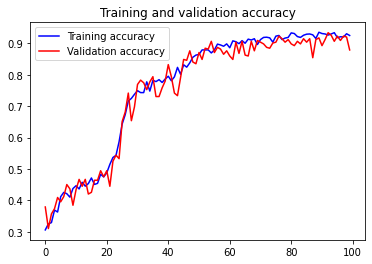

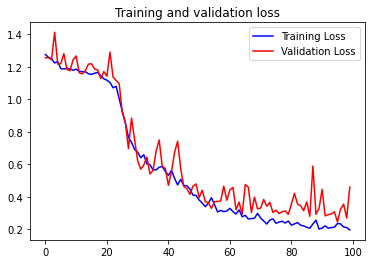

In [14]:
plot_acc_loss(history_2)

## Transfer learning
Transfer Learning is a method in which we use pre trained model, here we are using inception model.
The top layer (input and output layer) is removed, and added according to this project.
We are not training the inception layers, only the top layers will be trained.

In [18]:
# Pretrained Inception Model
inception = InceptionV3(input_shape = (150, 150, 3), # input image
                                include_top = False)# top layers are not included

for layer in inception.layers:# making layers of inception not traininable
    layer.trainable = False
    
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_12[0][0]']              
 alization)                                                                                       
                                                                                       

In [19]:
#Using the 'mixed7' layer as the last layer of pre trained model
last_layer = inception.get_layer('mixed7') # Mixed 7 layer
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output # this layer is used as a last layer of this model

last layer output shape:  (None, 7, 7, 768)


In [20]:
#Adding Last layer as per the requirement of the project
x = Flatten()(last_output) # flattening
x = Dense(1024, activation='relu')(x) # Dense layers with 1024 neuraons
x = Dropout(0.2)(x) # Dropout layer to reduce overfitting                   
x = Dense  (4, activation='softmax')(x) # sigmoid layer           

model3 = Model( inception.input, x) 

model3.compile(optimizer = Adam(), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    batch_size = 128,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     


validation_generator =  test_datagen.flow_from_directory( VAL_PATH,
                                                          batch_size  = 128,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 1457 images belonging to 4 classes.
Found 364 images belonging to 4 classes.


In [22]:
history3 = model3.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 100, callbacks = [callback])

Epoch 1/100
12/12 [==============================] - 29s 2s/step - loss: 8.3243 - accuracy: 0.3638 - val_loss: 2.0294 - val_accuracy: 0.4808
Epoch 2/100
12/12 [==============================] - 36s 3s/step - loss: 1.6005 - accuracy: 0.5319 - val_loss: 1.0510 - val_accuracy: 0.5797
Epoch 3/100
12/12 [==============================] - 49s 4s/step - loss: 0.8147 - accuracy: 0.6960 - val_loss: 0.6726 - val_accuracy: 0.7637
Epoch 4/100
12/12 [==============================] - 25s 2s/step - loss: 0.6918 - accuracy: 0.7509 - val_loss: 0.6304 - val_accuracy: 0.7582
Epoch 5/100
12/12 [==============================] - 25s 2s/step - loss: 0.6496 - accuracy: 0.7612 - val_loss: 0.6023 - val_accuracy: 0.7610
Epoch 6/100
12/12 [==============================] - 23s 2s/step - loss: 0.5926 - accuracy: 0.7879 - val_loss: 0.6035 - val_accuracy: 0.7720
Epoch 7/100
12/12 [==============================] - 23s 2s/step - loss: 0.5827 - accuracy: 0.7982 - val_loss: 0.5455 - val_accuracy: 0.7857
Epoch 8/100
1

KeyboardInterrupt: 

In [ ]:
model3.save('model_3.h5')

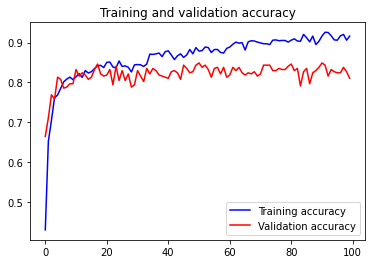

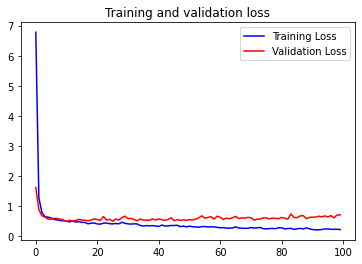

In [18]:
plot_acc_loss(history3)

In [15]:
def predict_new_image(img_path, model_path, classes):
    """This function outputs the class given for a path of the image and the model."""
    
    model = load_model(model_path)
    show_img = plt.imread(img_path)
    plt.imshow(show_img)

    
    f = open(img_path, "r")
    content = f.read()
    img = Image.open(io.BytesIO(content))
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    target_size = (150, 150)
    img = img.resize(target_size, 0)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    prob = model.predict(x)
    
    print(prob)
    pred_class = classes[np.argmax(prob[0])]
    print(pred_class)
    
    plt.show()
    print('-'*20)
    
    return pred_class